### **A3** **TEAM** **ASSIGNMENT**

Team 1:

**Student** **names**:
1.   Sumaiya Abdullah Rage
2.   Ojasvini Malik
3.   Milan Jacob
4.   Italo Hidalgo Castillo
5.   Sarah Buring
6.   Bunthorn Soth


**Title:** Comprehensive Analysis of Grocery Dataset for Business Insights

## **Introduction**


In today's competitive retail landscape, understanding customer preferences and product performance is critical for businesses to make data-driven decisions. This project aims to provide a comprehensive analysis of a grocery dataset to uncover valuable insights that can drive strategic business decisions. The analysis includes sentiment analysis, topic modeling, and price analysis, focusing on key variables such as product descriptions, features, ratings, and prices.

**Objectives**:

- **Sentiment Analysis**:

  To analyze customer sentiments from product descriptions and understand their impact on product ratings.

  To identify the sentiment distribution across various products and categories.

- **Topic Modeling**:

 To uncover the underlying themes and topics within product features.

 To analyze the relationship between identified topics and product categories.

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install squarify

# **Initial** **Data** **Exploration**

In [ ]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt  # essential graphical output
import numpy as np               # mathematical essentials
import pandas as pd              # data sceince essentials
import plotly.express as px
import seaborn as sns            # enhanced visualizations
from scipy import stats
import re
import nltk
import squarify
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords

from gensim import corpora, models
# Long Coding Box

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval


np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
grocery_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GroceryDataset.csv")

In [ ]:
# Let's show the first rows of a DataFrame
grocery_df.head()

,Sub Category,Price,Discount,Rating,Title,Currency,Feature,Product Description
0,Bakery & Desserts,$56.99,No Discount,Rated 4.3 out of 5 stars based on 265 reviews.,"David’s Cookies Mile High Peanut Butter Cake, ...",$,"""10"""" Peanut Butter Cake\nCertified Kosher OU-...",A cake the dessert epicure will die for!Our To...
1,Bakery & Desserts,$159.99,No Discount,Rated 5 out of 5 stars based on 1 reviews.,"The Cake Bake Shop 8"" Round Carrot Cake (16-22...",$,Spiced Carrot Cake with Cream Cheese Frosting ...,"Due to the perishable nature of this item, ord..."
2,Bakery & Desserts,$44.99,No Discount,Rated 4.1 out of 5 stars based on 441 reviews.,"St Michel Madeleine, Classic French Sponge Cak...",$,100 count\nIndividually wrapped\nMade in and I...,Moist and buttery sponge cakes with the tradit...
3,Bakery & Desserts,$39.99,No Discount,Rated 4.7 out of 5 stars based on 9459 reviews.,"David's Cookies Butter Pecan Meltaways 32 oz, ...",$,Butter Pecan Meltaways\n32 oz 2-Pack\nNo Prese...,These delectable butter pecan meltaways are th...
4,Bakery & Desserts,$59.99,No Discount,Rated 4.5 out of 5 stars based on 758 reviews.,"David’s Cookies Premier Chocolate Cake, 7.2 lb...",$,"""10"" Four Layer Chocolate Cake\nCertified Kosh...",A cake the dessert epicure will die for!To the...


In [ ]:
# Let's check its structure
grocery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Sub Category         1757 non-null   object
 1   Price                1754 non-null   object
 2   Discount             1757 non-null   object
 3   Rating               682 non-null    object
 4   Title                1757 non-null   object
 5   Currency             1752 non-null   object
 6   Feature              1739 non-null   object
 7   Product Description  1715 non-null   object
dtypes: object(8)
memory usage: 109.9+ KB


In [ ]:
# Total number of rows in the DataFrame,length or number of observations in a DataFrame in pandas
grocery_df.shape[0]

1757

## <a id="data-cleaning-and-preprocessing"></a>Data Cleaning & Preprocessing


**Remove** **Unnecessary** **Columns**: Since "Currency" seems to be always $, it can be removed.

In [ ]:
# Remove unnecessary columns
grocery_df.drop(columns=['Currency'], inplace=True)

In [ ]:
grocery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Sub Category         1757 non-null   object
 1   Price                1754 non-null   object
 2   Discount             1757 non-null   object
 3   Rating               682 non-null    object
 4   Title                1757 non-null   object
 5   Feature              1739 non-null   object
 6   Product Description  1715 non-null   object
dtypes: object(7)
memory usage: 96.2+ KB


Clean **Price** Column: Remove the **$** sign and convert the column to **numeric**

In [ ]:
# Function to clean price values
def clean_price(price):
    try:
        # Remove dollar sign and whitespace
        price = str(price).replace('$', '').replace(' ', '')
        if 'through-' in price:
            # Handle ranges
            low, high = price.split('through-')
            return (float(low) + float(high)) / 2
        else:
            return float(price.replace(',', ''))
    except ValueError:
        return None

# Apply the clean_price function to the Price column
grocery_df['Price'] = grocery_df['Price'].apply(clean_price)

# Check for any remaining non-numeric values (should be none)
non_numeric_prices = grocery_df[pd.to_numeric(grocery_df['Price'], errors='coerce').isna()]

# Convert the Price column to numeric, coercing errors to NaN
grocery_df['Price'] = pd.to_numeric(grocery_df['Price'], errors='coerce')

# Remove rows with NaN prices
grocery_df_cleaned = grocery_df.dropna(subset=['Price'])

In [ ]:
# Remove $ sign
grocery_df_cleaned.head()

,Sub Category,Price,Discount,Rating,Title,Feature,Product Description
0,Bakery & Desserts,56.99,No Discount,Rated 4.3 out of 5 stars based on 265 reviews.,"David’s Cookies Mile High Peanut Butter Cake, ...","""10"""" Peanut Butter Cake\nCertified Kosher OU-...",A cake the dessert epicure will die for!Our To...
1,Bakery & Desserts,159.99,No Discount,Rated 5 out of 5 stars based on 1 reviews.,"The Cake Bake Shop 8"" Round Carrot Cake (16-22...",Spiced Carrot Cake with Cream Cheese Frosting ...,"Due to the perishable nature of this item, ord..."
2,Bakery & Desserts,44.99,No Discount,Rated 4.1 out of 5 stars based on 441 reviews.,"St Michel Madeleine, Classic French Sponge Cak...",100 count\nIndividually wrapped\nMade in and I...,Moist and buttery sponge cakes with the tradit...
3,Bakery & Desserts,39.99,No Discount,Rated 4.7 out of 5 stars based on 9459 reviews.,"David's Cookies Butter Pecan Meltaways 32 oz, ...",Butter Pecan Meltaways\n32 oz 2-Pack\nNo Prese...,These delectable butter pecan meltaways are th...
4,Bakery & Desserts,59.99,No Discount,Rated 4.5 out of 5 stars based on 758 reviews.,"David’s Cookies Premier Chocolate Cake, 7.2 lb...","""10"" Four Layer Chocolate Cake\nCertified Kosh...",A cake the dessert epicure will die for!To the...


**Duplicate**

In [ ]:
# Check for duplicates
duplicate_rows = grocery_df_cleaned[grocery_df_cleaned.duplicated()]
duplicate_rows

,Sub Category,Price,Discount,Rating,Title,Feature,Product Description
1344,Paper & Plastic Products,16.19,After $3.80 OFF,NaN,"Ziploc Seal Top Freezer Bag, Gallon, 38-count,...",Seal Top Bags 1-Gallon Freezer Bags 38 Bag...,4 - 38 Count Boxes\n152 Gallon Freezer Bags To...
1345,Paper & Plastic Products,16.19,After $3.80 OFF,NaN,"Ziploc Seal Top Freezer Bag, Gallon, 38-count,...",Seal Top Bags 1-Gallon Freezer Bags 38 Bag...,4 - 38 Count Boxes\n152 Gallon Freezer Bags To...
1346,Paper & Plastic Products,16.19,After $3.80 OFF,NaN,"Ziploc Seal Top Freezer Bag, Gallon, 38-count,...",Seal Top Bags 1-Gallon Freezer Bags 38 Bag...,4 - 38 Count Boxes\n152 Gallon Freezer Bags To...


In [ ]:
# Remove duplicates
df_grocery = grocery_df_cleaned.drop_duplicates()

# Display the number of duplicate rows
num_duplicates = len(duplicate_rows)
num_duplicates

3

In [ ]:
# Let's Check for duplicates again
duplicate_rows = df_grocery[df_grocery.duplicated()]
duplicate_rows

,Sub Category,Price,Discount,Rating,Title,Feature,Product Description


**Missing** **values**

In [ ]:
# How many null values we have per column
df_grocery.isna().sum()

Sub Category              0
Price                     0
Discount                  0
Rating                 1071
Title                     0
Feature                  18
Product Description      42
dtype: int64

I analyze the importance of all missing values in each column in order to understand the significance.

In [ ]:
A=((df_grocery['Rating'].isnull().sum())/ df_grocery.shape[0])*100
B=((df_grocery['Feature'].isnull().sum())/ df_grocery.shape[0])*100
C=((df_grocery['Product Description'].isnull().sum())/ df_grocery.shape[0])*100


print(f'Importance Rating:{A:.2f}%')
print(f'Importance Feature:{B:.2f}%')
print(f'Importance Product Description:{C:.2f}%')

Importance Rating:61.17%
Importance Feature:1.03%
Importance Product Description:2.40%


In [ ]:
# Removing blank values for 'df_grocery'
df_grocery.dropna(subset=['Feature', 'Product Description'],inplace=True)

In [ ]:
# Fill missing values in the Rating column with the string "NaN"
df_grocery['Rating'].fillna("NaN", inplace=True)

# **Exploratory Data Analysis (EDA)**:

In [ ]:
# Generate basic descriptive statistics for the 'df_grocery' DataFrame
df_grocery.describe()

,Price
count,1693.000000
mean,62.728311
std,123.306899
min,3.990000
25%,14.990000
50%,24.990000
75%,54.990000
max,1999.990000


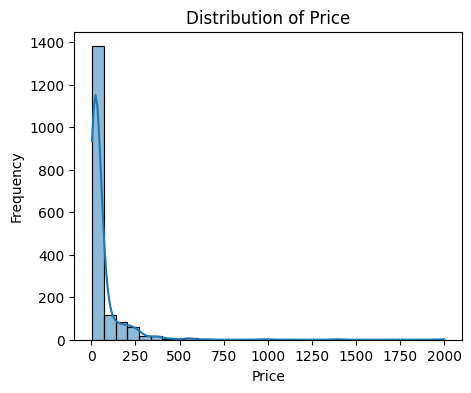

In [ ]:
# Plotting the distribution of the 'Price' column
plt.figure(figsize=(5, 4))
sns.histplot(df_grocery['Price'], bins=30, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

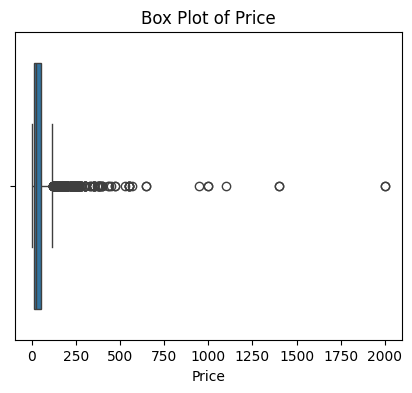

In [ ]:
# Box plot for 'Price'
plt.figure(figsize=(5, 4))
sns.boxplot(x=df_grocery['Price'])
plt.title('Box Plot of Price')
plt.xlabel('Price')
plt.show()

The price analysis shows a highly skewed distribution with most products priced between $0 and $250, and a few outliers up to $2000. This indicates a focus on affordability with some high-value items.

Implications: The business should review the pricing of high-value items to ensure competitiveness and value. There is an opportunity to introduce mid-range products to capture a broader market segment. Understanding price sensitivity can help tailor marketing strategies for different customer segments.

Recommendations: Analyze products priced above 500 dollar to understand their value proposition and consider targeted marketing. Introduce new products in the $250-$500 range to fill the gap. Implement promotions for lower-priced items to attract price-sensitive customers and value-based promotions for higher-priced items. Continuously monitor price trends and adjust strategies based on market demand and customer feedback.

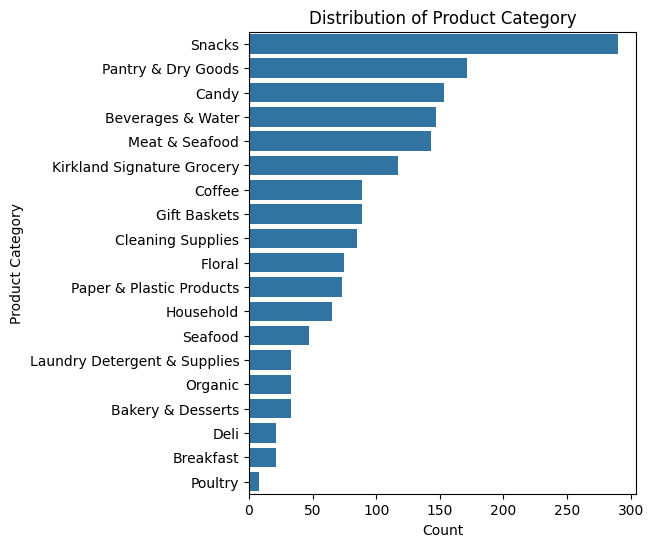

In [ ]:
# Bar chart for 'Product Category'
plt.figure(figsize=(5, 6))
sns.countplot(y='Sub Category', data=df_grocery, order=df_grocery['Sub Category'].value_counts().index)
plt.title('Distribution of Product Category')
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.show()

The analysis shows that "Snacks," "Pantry & Dry Goods," "Candy," and "Beverages & Water" are the most common categories, indicating high demand. In contrast, categories like "Poultry," "Breakfast," and "Deli" have the lowest counts.

Implications: High-demand categories should guide inventory and marketing strategies. Low counts in certain categories may indicate areas for potential growth or need reassessment.

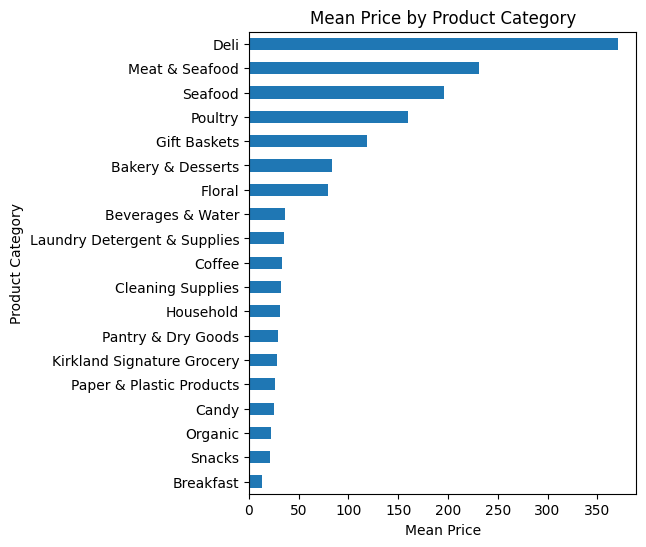

In [ ]:
# Group by 'Product Category' and calculate mean price
mean_price_by_category = df_grocery.groupby('Sub Category')['Price'].mean().sort_values()
plt.figure(figsize=(5, 6))
mean_price_by_category.plot(kind='barh')
plt.title('Mean Price by Product Category')
plt.xlabel('Mean Price')
plt.ylabel('Product Category')
plt.show()

The analysis of mean prices by product category reveals that "Deli," "Meat & Seafood," and "Seafood" categories have the highest average prices, indicating these are premium categories. On the other hand, "Breakfast," "Snacks," and "Organic" categories have the lowest mean prices, suggesting they are more budget-friendly.

Implications: The high mean prices in "Deli" and "Meat & Seafood" suggest these categories can be marketed as premium products. Lower-priced categories like "Breakfast" and "Snacks" can be leveraged to attract price-sensitive customers and drive volume sales.

## **Analytical Techniques**:

### **Sentiment Analysis:**

**Objective**: Understand how the sentiment in product descriptions correlates with customer ratings.
**Approach**: Perform sentiment analysis on product descriptions and analyze the average ratings for positive, neutral, and negative sentiments.

In [ ]:
# Ensure you have downloaded the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

**Text** **Preprocessing**

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation but keep numbers
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'Product Description' column
df_grocery['cleaned_description'] = df_grocery['Product Description'].apply(preprocess_text)

- **Extract** **Numerical** **Rating** **and** **Number** **of** **Reviews** **from** **the** **Rating** **Column**

In [ ]:
# Function to extract rating and number of reviews
def extract_rating_and_reviews(rating_text):
    # Use regex to find the first occurrence of a floating point number for the rating
    rating_match = re.search(r'(\d+\.\d+)', rating_text)
    rating = float(rating_match.group(1)) if rating_match else None

    # Use regex to find the number of reviews
    reviews_match = re.search(r'based on (\d+) reviews', rating_text)
    reviews = int(reviews_match.group(1)) if reviews_match else None

    return rating, reviews

# Apply the extraction function to the 'Rating' column
df_grocery[['numeric_rating', 'num_reviews']] = df_grocery['Rating'].apply(lambda x: pd.Series(extract_rating_and_reviews(x)))

- **Apply** **VADER** **Sentiment** **Analysis** **to** **the** **Product** **Description** **Column**

In [ ]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def get_sentiment(text):
    return sid.polarity_scores(text)

# Apply sentiment analysis on the 'cleaned_description' column
df_grocery['sentiment'] = df_grocery['cleaned_description'].apply(lambda x: get_sentiment(x))

# Extract compound sentiment scores
df_grocery['compound'] = df_grocery['sentiment'].apply(lambda x: x['compound'])

# Classify sentiment as positive, neutral, or negative
df_grocery['sentiment_label'] = df_grocery['compound'].apply(lambda c: 'positive' if c > 0 else ('negative' if c < 0 else 'neutral'))


- **Correlation** **Analysis**: Analyze Sentiment and Ratings

In [ ]:
# Calculate average ratings for each sentiment category
avg_ratings_by_sentiment = df_grocery.groupby('sentiment_label')['numeric_rating'].mean()

# Explore correlations
correlation = df_grocery['compound'].corr(df_grocery['numeric_rating'])


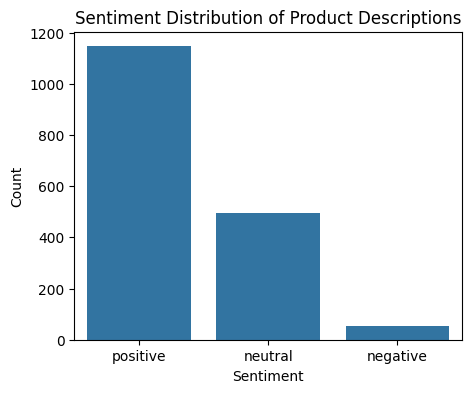

In [ ]:
# Bar chart for sentiment distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='sentiment_label', data=df_grocery, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of Product Descriptions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


The sentiment analysis shows that most product descriptions have positive sentiments, followed by neutral, and very few negative sentiments. The correlation analysis indicates a positive relationship between sentiment scores and product ratings, with positive sentiments having higher average ratings.

Implications: Positive customer sentiment correlates with higher ratings, suggesting that improving product descriptions and addressing negative feedback can enhance overall product ratings and customer satisfaction.

- **Visualize** **Ratings** **by** **Sentiment**

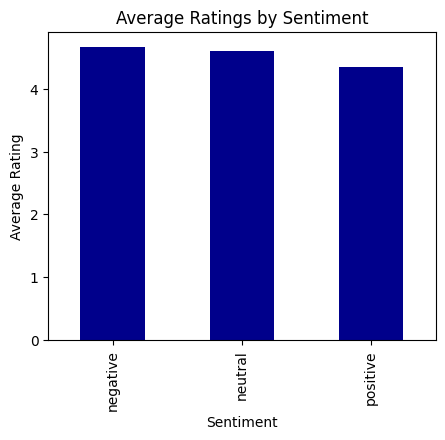

In [ ]:
# Bar chart for average ratings by sentiment
plt.figure(figsize=(5, 4))
avg_ratings_by_sentiment.plot(kind='bar', color='#00008B')
plt.title('Average Ratings by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Rating')
plt.show()

The analysis shows that average ratings are consistently high across all sentiment categories—positive, neutral, and negative—with ratings around 4.5 out of 5. This indicates a generally high level of customer satisfaction regardless of sentiment.

Implications: High average ratings across all sentiments suggest that customers are generally satisfied with the products. Even products with neutral or negative sentiments still receive high ratings, indicating potential areas where product descriptions or features could be improved to shift sentiments positively.

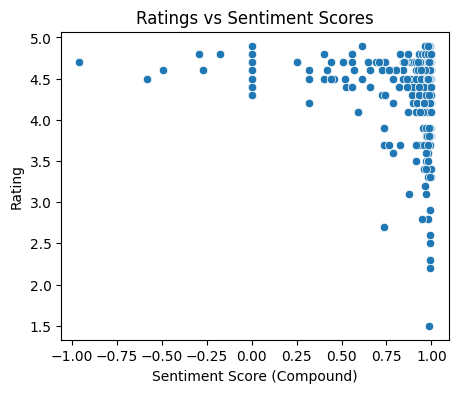

In [ ]:
# Scatter plot for ratings vs sentiment scores
plt.figure(figsize=(5, 4))
sns.scatterplot(x='compound', y='numeric_rating', data=df_grocery)
plt.title('Ratings vs Sentiment Scores')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Rating')
plt.show()

The scatter plot shows a positive correlation between sentiment scores and ratings. Products with higher sentiment scores tend to have higher ratings, indicating that positive sentiments are associated with better product ratings. Most products cluster around high sentiment scores and ratings, with few products showing negative sentiments.

Implications: This strong correlation suggests that improving the sentiment of product descriptions and addressing negative feedback can lead to higher product ratings. Positive customer sentiments are key drivers of high ratings.

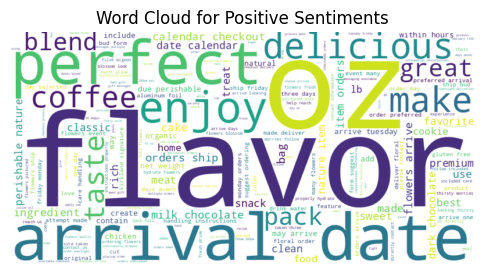

In [ ]:
# Word Cloud for Positive Sentiments
positive_text = ' '.join(df_grocery[df_grocery['sentiment_label'] == 'positive']['cleaned_description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiments')
plt.axis('off')
plt.show()

The word cloud for positive sentiments highlights frequently mentioned words such as "flavor," "perfect," "enjoy," and "delicious," indicating that customers value taste and quality highly in their product reviews.

Implications: The emphasis on words related to taste and quality suggests that these attributes are crucial for customer satisfaction. Products that excel in these areas are more likely to receive positive feedback.

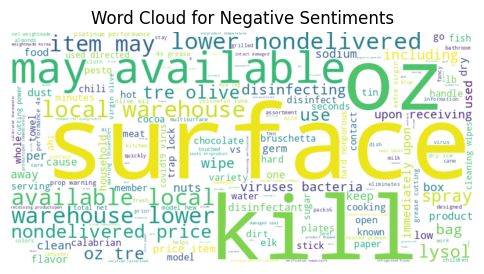

In [ ]:
# Word Cloud for Negative Sentiments
negative_text = ' '.join(df_grocery[df_grocery['sentiment_label'] == 'negative']['cleaned_description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiments')
plt.axis('off')
plt.show()

The word cloud for negative sentiments highlights frequently mentioned words such as "surface," "kill," "available," and "may," indicating concerns about product availability and effectiveness.

Implications: Negative sentiments are centered around product availability and effectiveness, suggesting these are areas where customers experience dissatisfaction.

### **Topic Modeling**

**Objective**: Identify common themes in product features and how they relate to different product categories.
**Approach**: Apply topic modeling to the Feature column and analyze the distribution of topics across different Sub Categories

**Text** **Preprocessing**

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation but keep numbers
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'Feature' column
df_grocery['cleaned_feature'] = df_grocery['Feature'].apply(preprocess_text)

- **BoW** and **TF**-**IDF** Transformation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create BoW and TF-IDF representations
vectorizer_bow = CountVectorizer()
vectorizer_tfidf = TfidfVectorizer()

# Fit and transform the cleaned descriptions
bow_matrix = vectorizer_bow.fit_transform(df_grocery['cleaned_feature'])
tfidf_matrix = vectorizer_tfidf.fit_transform(df_grocery['cleaned_feature'])

# Convert BoW and TF-IDF to gensim corpus format
from gensim import corpora

dictionary_bow = corpora.Dictionary(df_grocery['cleaned_feature'].apply(lambda x: x.split()))
corpus_bow = [dictionary_bow.doc2bow(text) for text in df_grocery['cleaned_feature'].apply(lambda x: x.split())]

dictionary_tfidf = corpora.Dictionary(df_grocery['cleaned_feature'].apply(lambda x: x.split()))
corpus_tfidf = [dictionary_tfidf.doc2bow(text) for text in df_grocery['cleaned_feature'].apply(lambda x: x.split())]


- **Build** **LDA** **Models** **Using** **BoW** and **TF**-IDF Representations

In [ ]:
from gensim.models import LdaModel

# Build LDA model with BoW
lda_model_bow = LdaModel(corpus=corpus_bow, num_topics=5, id2word=dictionary_bow, passes=10)

# Build LDA model with TF-IDF
lda_model_tfidf = LdaModel(corpus=corpus_tfidf, num_topics=5, id2word=dictionary_tfidf, passes=10)


- **Print** **the** **Top** **Words** **in** **Each** **Topic**

In [ ]:
# Print the topics for BoW
topics_bow = lda_model_bow.print_topics(num_words=5)
print("LDA Model with BoW Topics:")
for topic in topics_bow:
    print(topic)

LDA Model with BoW Topics:
(0, '0.026*"oz" + 0.022*"kosher" + 0.016*"chocolate" + 0.015*"free" + 0.012*"weight"')
(1, '0.034*"oz" + 0.022*"total" + 0.014*"fl" + 0.013*"12" + 0.011*"per"')
(2, '0.023*"oz" + 0.021*"ships" + 0.019*"coffee" + 0.019*"frozen" + 0.014*"roast"')
(3, '0.039*"free" + 0.032*"oz" + 0.030*"kosher" + 0.029*"net" + 0.028*"weight"')
(4, '0.033*"checkout" + 0.019*"animal" + 0.019*"available" + 0.018*"consumption" + 0.018*"human"')


The topic modeling using Bag of Words (BoW) highlights key themes such as "oz," "kosher," "chocolate," "free," and "checkout." These terms indicate significant attributes related to product size, dietary preferences, product type, and shopping processes.

Implications: These key terms suggest that customers value specific product attributes like size and dietary options, and they are concerned with certain aspects of the shopping experience, such as checkout efficiency.

In [ ]:
# Print the topics for TF-IDF
topics_tfidf = lda_model_tfidf.print_topics(num_words=5)
print("LDA Model with TF-IDF Topics:")
for topic in topics_tfidf:
    print(topic)

LDA Model with TF-IDF Topics:
(0, '0.035*"free" + 0.026*"kosher" + 0.026*"oz" + 0.019*"organic" + 0.016*"gluten"')
(1, '0.036*"oz" + 0.019*"kosher" + 0.017*"net" + 0.017*"weight" + 0.013*"total"')
(2, '0.027*"checkout" + 0.015*"animal" + 0.015*"available" + 0.015*"warning" + 0.015*"human"')
(3, '0.026*"oz" + 0.020*"ships" + 0.019*"frozen" + 0.017*"total" + 0.015*"uncooked"')
(4, '0.025*"chocolate" + 0.023*"oz" + 0.021*"free" + 0.014*"individually" + 0.013*"kosher"')


The topic modeling using TF-IDF reveals key themes across the product descriptions, with significant terms including "free," "kosher," "oz," "organic," and "checkout." These terms indicate important product attributes such as dietary preferences, size, and shopping processes.

Implications: Customers value dietary options, product size, and efficient shopping processes. These insights can guide product development and marketing strategies.

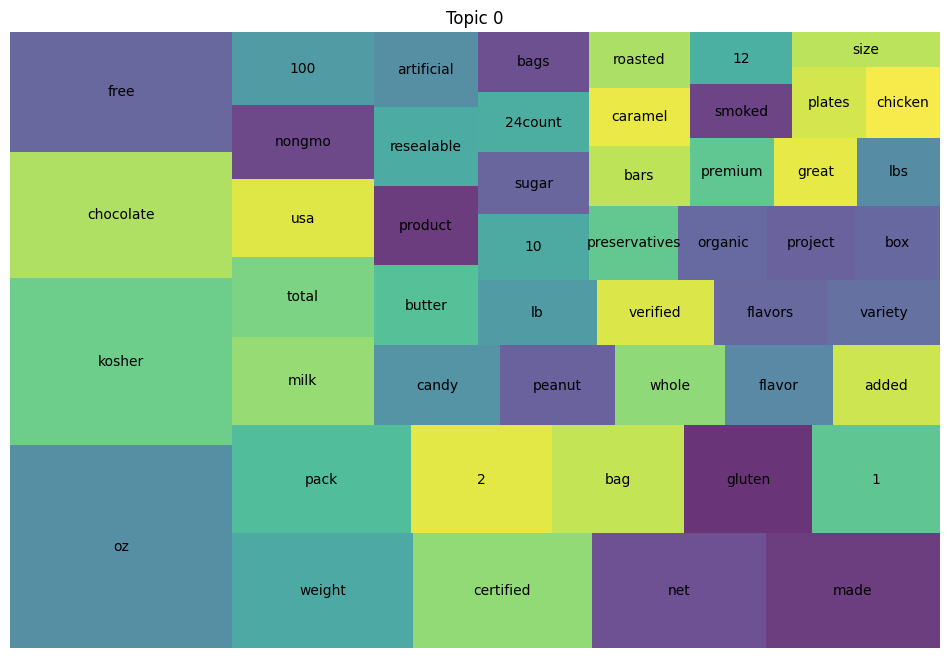

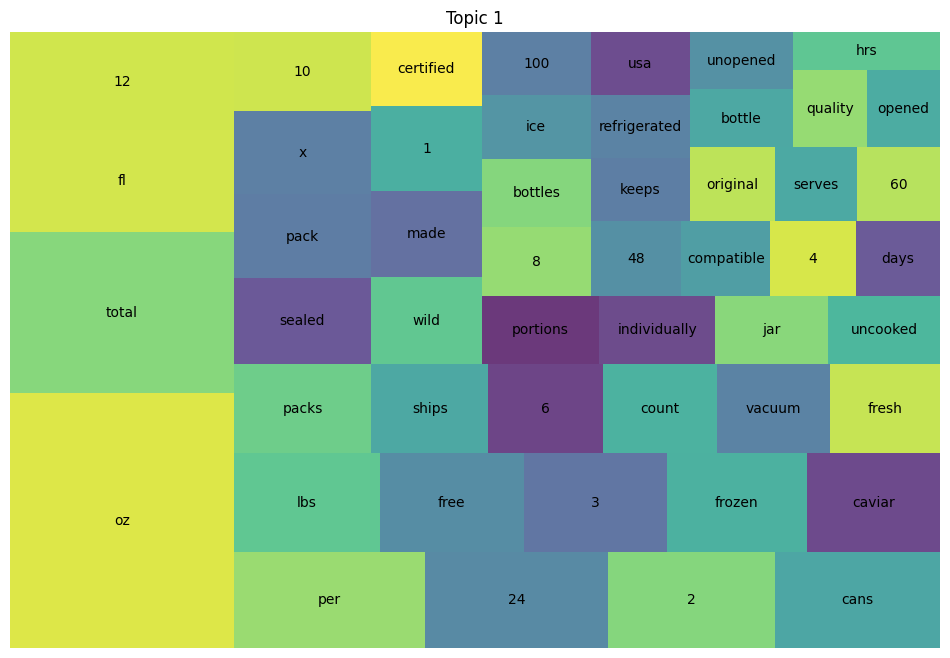

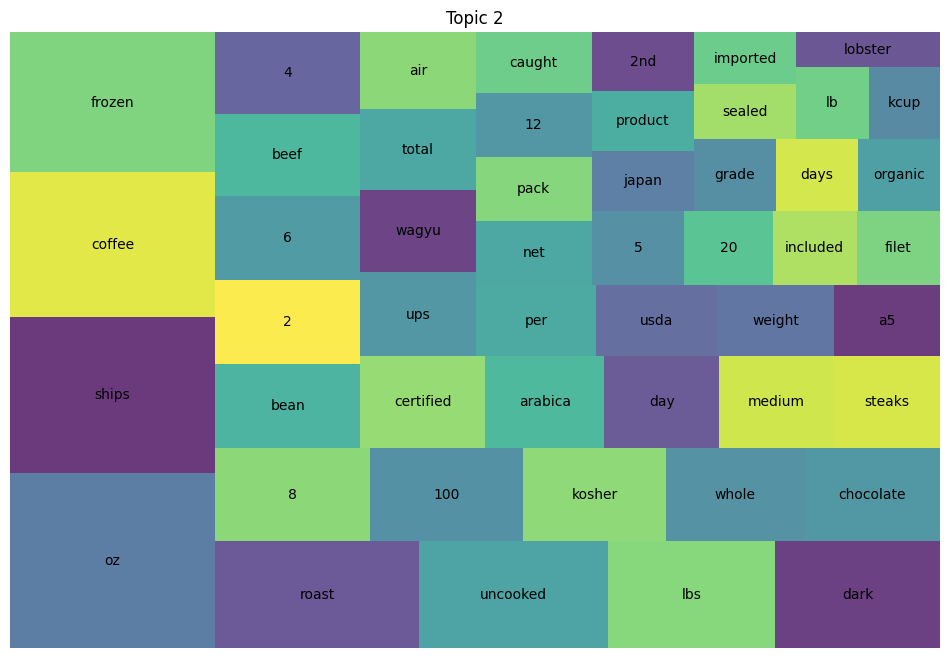

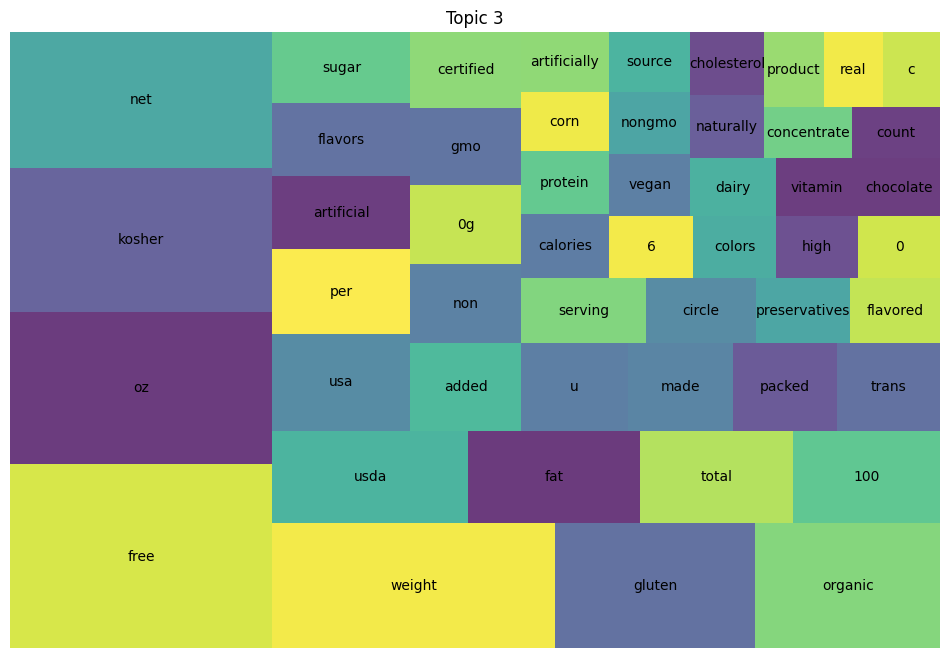

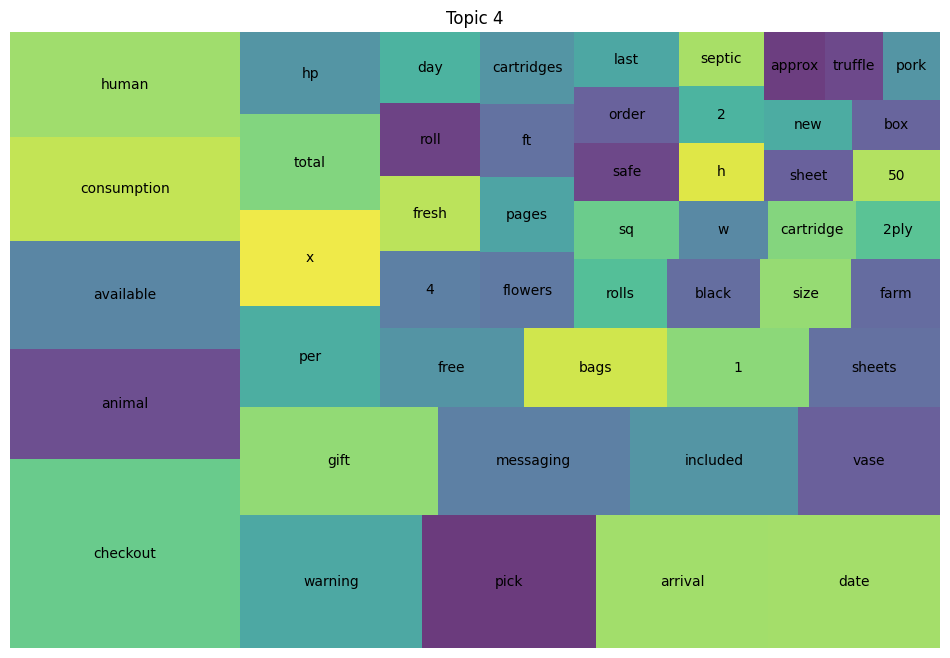

In [ ]:
# Assuming you have already built your LDA model (lda_model_bow) and corpus (corpus_bow)
# Extract topics and their associated words
topics = lda_model_bow.show_topics(formatted=False, num_words=50)

# Function to extract word frequencies for each topic
def extract_word_frequencies(topics):
    word_freqs = []
    for topic in topics:
        word_freq = {word: weight for word, weight in topic[1]}
        word_freqs.append(word_freq)
    return word_freqs

word_freqs = extract_word_frequencies(topics)

# Function to plot treemaps for each topic
def plot_treemap(word_freq, topic_num):
    labels = list(word_freq.keys())
    sizes = list(word_freq.values())

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=.8)
    plt.title(f'Topic {topic_num}')
    plt.axis('off')
    plt.show()

# Plot treemaps for each topic
for i, word_freq in enumerate(word_freqs):
    plot_treemap(word_freq, i)


- **Visualize** **the** **Topics** **Using** **pyLDAvis**

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the topics for BoW
pyLDAvis.enable_notebook()
lda_vis_bow = gensimvis.prepare(lda_model_bow, corpus_bow, dictionary_bow)
pyLDAvis.display(lda_vis_bow)

# Visualize the topics for TF-IDF
lda_vis_tfidf = gensimvis.prepare(lda_model_tfidf, corpus_tfidf, dictionary_tfidf)
pyLDAvis.display(lda_vis_tfidf)


## **Conclusion**

In this project, we analyzed a grocery dataset using sentiment analysis, topic modeling, and exploratory data analysis (EDA) to gain insights and make informed business decisions.

Our price analysis revealed that most products are priced below 250 Dollar, with a few outliers up to 2000 Dollar, suggesting a need to review the pricing of these outlier products. In terms of product categories, 'Snacks' and 'Pantry & Dry Goods' were the most common, indicating areas to focus inventory and marketing efforts. Sentiment analysis showed that most product descriptions had positive sentiments, reflecting overall customer satisfaction, but also highlighted areas needing improvement due to negative sentiments. We found a positive correlation between sentiment scores and product ratings, suggesting that enhancing features that drive positive sentiments can improve ratings.

Topic modeling identified key themes in product descriptions such as dietary preferences (e.g., kosher, organic), product sizes, and the shopping process. These insights can guide product development and targeted marketing strategies.

In summary, to improve business outcomes, we recommend optimizing prices, focusing on high-demand product categories, enhancing product features based on customer feedback, and creating targeted marketing campaigns. These steps can help increase customer satisfaction and drive sales growth.